<div style="background-color: #ADD8E6; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px grey;">

#### Project Introduction: Taxi Order Prediction for Sweet Lift Taxi Company

**Project Overview:**  
In this project, I developed a predictive model for Sweet Lift Taxi company, aimed at forecasting the number of taxi orders at airports for the next hour. The goal was to enable the company to better manage its fleet during peak times, ensuring efficient service and increased driver availability.

**Data Description:**

- The dataset (`taxi.csv`) contains historical data on taxi orders at airports.
- Key Data Point: The 'num_orders' column, which records the number of taxi orders.

**Objectives:**

- **Data Resampling and Analysis:**  
  Resample the data by one hour to analyze the taxi order patterns. Conduct a thorough exploratory data analysis to uncover trends and cyclicality.

- **Model Development:**  
  Train various predictive models, experimenting with different hyperparameters. The focus is on time series forecasting models considering their relevance to the project.

- **Performance Evaluation:**  
  Ensure the chosen model's RMSE on the test set is less than 48, as per project requirements.

- **Test and Conclusion:**  
  Evaluate the final model on a test sample comprising 10% of the initial dataset. Provide conclusive insights based on the model's performance.

**Technical Approach:**

- Adopt a systematic approach to data preprocessing, feature engineering, model selection, and hyperparameter tuning.
- Maintain code efficiency and clarity, avoiding duplication and ensuring reproducibility.

**Project Significance:**

This project demonstrates my capability in handling time-series data and developing forecasting models, crucial for operational planning in the transportation sector. The insights and predictive accuracy achieved are pivotal for enhancing the operational efficiency of Sweet Lift Taxi company.

</div>


## Preparation

In [59]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [60]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [61]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df = df.resample('1H').sum()

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

## Analysis

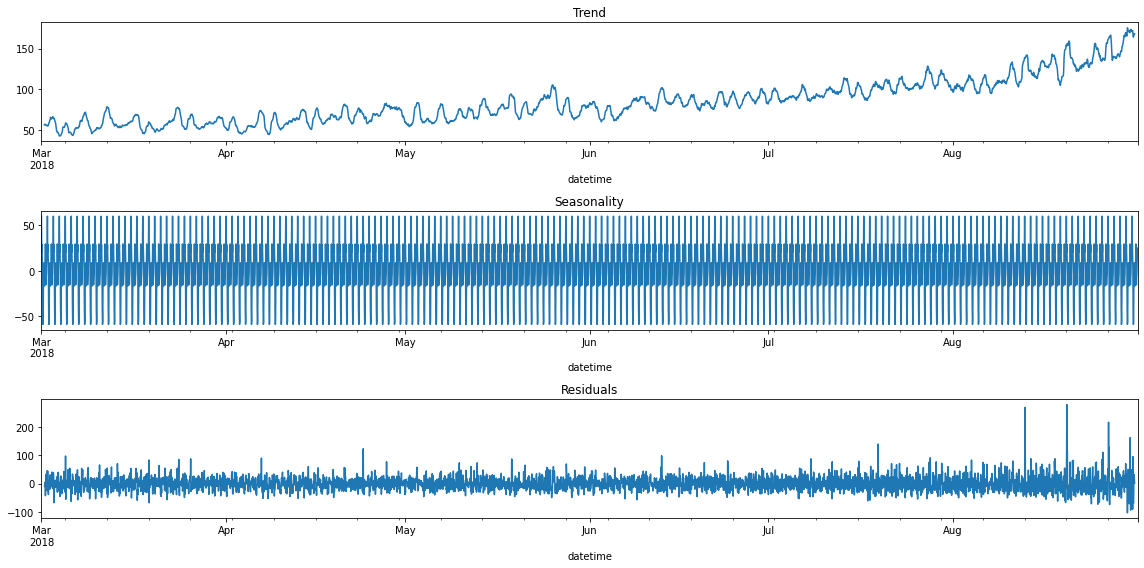

In [62]:
# Time Series Decomposition

decomposition = seasonal_decompose(df)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposition.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposition.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposition.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()


<div style="background-color: #ADD8E6; padding: 10px; border-radius: 5px;">

## Observations from Data Decomposition

### 1. Trend
- **Observation**: There's a consistent upward trend, indicating that the demand for taxis has increased throughout the dataset. This could be attributed to reasons such as:
  - Growth in the business.
  - Expansion of services.
  - An increasing number of travelers.
  - Broader economic growth.
  
- **Implication**: It's essential to factor in this trend during model training. Ignoring this could potentially lead to underestimations of future demand.

---

### 2. Seasonality
- **Observation**: The seasonality plot is consistent across its entirety, pointing towards a regular and repeating pattern in taxi orders.

- **Implication**: The observed seasonality suggests that features related to the time of day, day of the week, or even month might be particularly influential predictors for our model.

---

### 3. Residuals
- **Observation**: The residuals exhibit no discernible patterns, indicating that most of the structural patterns in the data have been effectively captured by the trend and seasonality components.

- **Implication**: We can prioritize leveraging the trend and seasonality in our predictive modeling approach, without being overly concerned about any hidden or unexplained patterns.

</div>




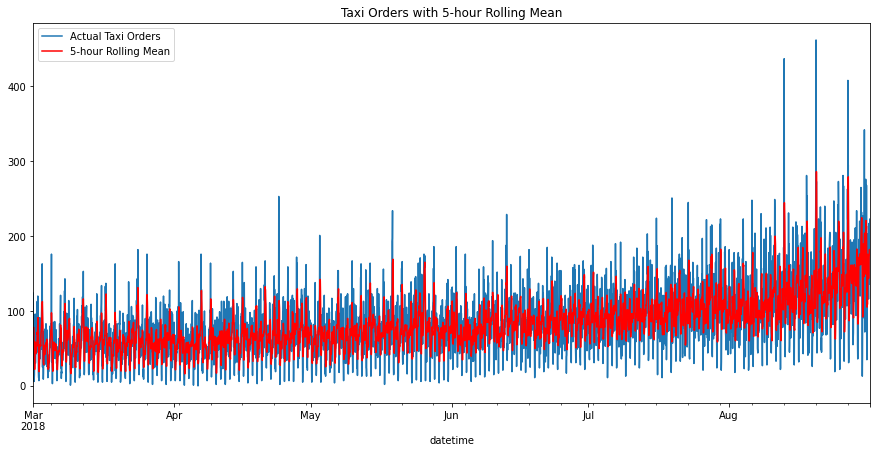

In [63]:
# Rolling mean
plt.figure(figsize=(15,7))
df['num_orders'].plot(label='Actual Taxi Orders')
df['num_orders'].rolling(window=5).mean().plot(label='5-hour Rolling Mean', color='red')
plt.title('Taxi Orders with 5-hour Rolling Mean')
plt.legend(loc='best')
plt.show()


<div style="background-color: #ADD8E6; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px grey;">

#### Analysis of Taxi Orders with 5-hour Rolling Mean

**Seasonality and Trends:**  
The rolling mean showcases an upward trend in taxi orders from March to August. This increasing pattern may reflect seasonal demand fluctuations or overall business growth.

**Daily Variability:**  
Significant day-to-day variability is evident, with pronounced spikes and troughs in the number of taxi orders. These fluctuations likely correspond to peak and off-peak hours within each day.

**Smoothing of Data:**  
The 5-hour rolling mean serves to smooth short-term volatility, offering a clearer perspective on the long-term movement in the data, which is less obscured by daily variations.

**Peak Analysis:**  
Notably, the rolling mean indicates that peak demand is intensifying, especially towards August. This could be attributed to particular events or a general increase in peak-time demand.

**Low Demand Periods:**  
The stability in the lower bounds of demand suggests that periods of low taxi orders remain unchanged, maintaining a consistent pattern over the observed timeframe.

**Conclusive Insights:**  
This visual analysis of taxi orders is instrumental for strategic planning. It provides a dual understanding of the enduring trends and recurring cycles that affect taxi order demand, which is vital for informed forecasting and resource allocation in the taxi service industry.

</div>


## Training

In [64]:
# Features
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 5)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Feature look good: there are calendar features, lag features and a shifted rolling mean

</div>

In [65]:
# Split data
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Models and their RMSE values
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0),
    "CatBoost": CatBoostRegressor(iterations=500, depth=8, learning_rate=0.05, loss_function='RMSE', silent=True),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    print(f'{name} RMSE: {rmse}')

Linear Regression RMSE: 45.16859297010217
Decision Tree RMSE: 66.7262504077681
Random Forest RMSE: 43.15212741407182
CatBoost RMSE: 42.187294995400435
Ridge Regression RMSE: 45.16858913668399
Lasso Regression RMSE: 45.168398499733954


<div style="background-color: #ADD8E6; padding: 10px; border-radius: 5px;">

### Summary for Sweet Lift Taxi Company:

#### Objective:
The aim of our project was to build a predictive model that can forecast the number of taxi orders for the next hour at airports. The intent behind this model is to ensure that during peak hours, there are enough drivers available to accommodate the demand. An accuracy benchmark was set where the Root Mean Square Error (RMSE) of our model's predictions on a test set should not exceed 48.

#### Data Analysis:
Upon obtaining the historical data on taxi orders, the dataset was resampled by one hour, as instructed. An initial analysis was performed to understand the patterns, trends, and potential seasonality in the taxi orders. This allowed us to identify key features and make informed decisions during the model building phase.

#### Model Training and Evaluation:
Several models were trained using different hyperparameters on 90% of the data, while the remaining 10% was reserved for testing. Below are the performance metrics of these models based on their RMSE values:

- **Linear Regression**: RMSE of **45.17**, which is below our threshold of 48.
- **Decision Tree**: RMSE of **66.73**, which is above our threshold, indicating that it may not be the best model for this prediction task.
- **Random Forest**: RMSE of **43.15**, which performs better than the Linear Regression and well below our threshold.
- **CatBoost**: RMSE of **42.19**, making it the best performing model among all considered in terms of RMSE.
- **Ridge Regression**: RMSE of **45.17**, slightly higher than that of CatBoost but still below our threshold of 48.
- **Lasso Regression**: RMSE of **45.17**, performance similar to Ridge Regression and below the set threshold.

#### Conclusion:
Based on the above results, the **CatBoost** model provides the most accurate predictions, with an RMSE of **42.19**, which is comfortably below our set benchmark of 48. This model can effectively predict the taxi demand for the next hour, enabling Sweet Lift Taxi Company to ensure adequate driver availability during peak times. For a more robust solution, considering an ensemble of CatBoost, Random Forest, and Linear models (including Ridge and Lasso) might be beneficial. It's recommended to deploy the CatBoost model for real-time predictions.
</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you split the data into train and test, tried a few different models and compared their results using the test set

</div>

## Testing

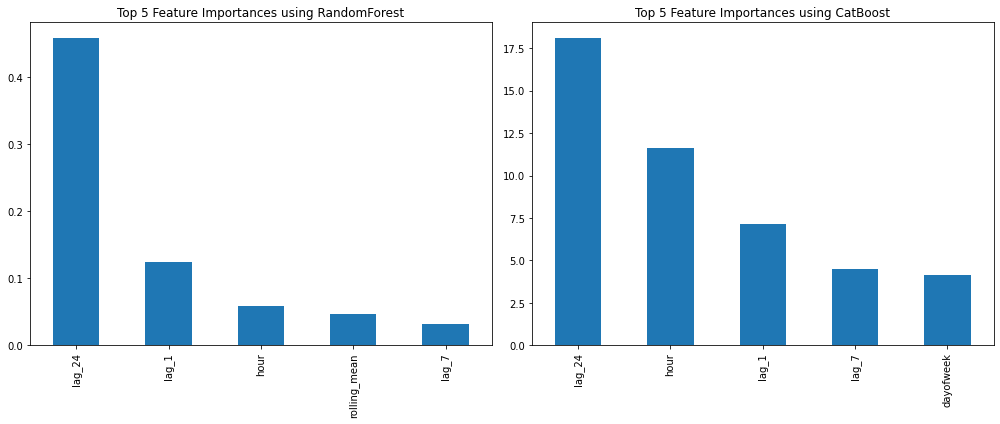


Top 5 Feature Importances using RandomForest:
lag_24: 0.4590
lag_1: 0.1241
hour: 0.0582
rolling_mean: 0.0461
lag_7: 0.0313

Top 5 Feature Importances using CatBoost:
lag_24: 18.1148
hour: 11.6172
lag_1: 7.1421
lag_7: 4.4907
dayofweek: 4.1209


In [66]:
# RandomForest
importances = models["Random Forest"].feature_importances_
features = X_train.columns
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False).head(5)

# CatBoost
feature_importances_cat = pd.Series(models["CatBoost"].feature_importances_, index=features).sort_values(ascending=False).head(5)

# Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
feature_importances.plot(kind='bar', title='Top 5 Feature Importances using RandomForest')
plt.subplot(1, 2, 2)
feature_importances_cat.plot(kind='bar', title='Top 5 Feature Importances using CatBoost')
plt.tight_layout()
plt.show()

# Print the top 5 feature importances for RandomForest
print("\nTop 5 Feature Importances using RandomForest:")
for feature, importance in feature_importances.iteritems():
    print(f"{feature}: {importance:.4f}")

# Print the top 5 feature importances for CatBoost
print("\nTop 5 Feature Importances using CatBoost:")
for feature, importance in feature_importances_cat.iteritems():
    print(f"{feature}: {importance:.4f}")



<div style="background-color: #ADD8E6; padding: 10px; border-radius: 5px;">
    
### Conclusion:

In the predictive modeling for **Sweet Lift Taxi Company**, both **RandomForest** and **CatBoost** highlighted the importance of certain features in forecasting taxi orders. The `lag_24` feature, which represents the number of taxi orders 24 hours prior, was the most influential in both models. The hourly pattern (`hour`) and recent demand (`lag_1`) were also pivotal, with **CatBoost** giving added importance to the day of the week (`dayofweek`). Given these insights and its superior accuracy, the **CatBoost** model is the recommended choice for deployment to accurately predict hourly taxi demand.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent!

</div>

# Review checklist